In [1]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add
import re

import random
import hashlib


Processing alpha=0, using discriminant: score_hh4bvsqcd
Loaded QCD ratios (vsqcd) from qcd_ratio_fitted_results_0p99.npz

Processing model: ensemble
Using QCD Ratio: 0.07271861661227572
Loaded saved ROC data.
Event-level classifier - Sig: 248.20, Bg: 3723681.00
Downsampling from 778832 points...

  [Downsample] Starting with 778832 points
  bg_events range: [0.00e+00, 3.72e+06]
  [Downsample] Region breakdown:
    Ultra low (< 1): 280 → 280 (kept all)
    Extreme low (1-10): 132 → 132
    Low (10-100): 666 → 666
    Mid (100-1000): 2380 → 505
    High (≥ 1000): 775374 → 498
  [Downsample] Total: 778832 → 2081 points

-------------------------------------------------------------------------------------
Event-level classifier - Benchmark Results:
Target Sig   | Actual Sig   | Threshold  | Total Bg     | QCD          | TTbar       
-------------------------------------------------------------------------------------
20.000       | 20.006       | 0.999910772 | 103.475      | 26.052       

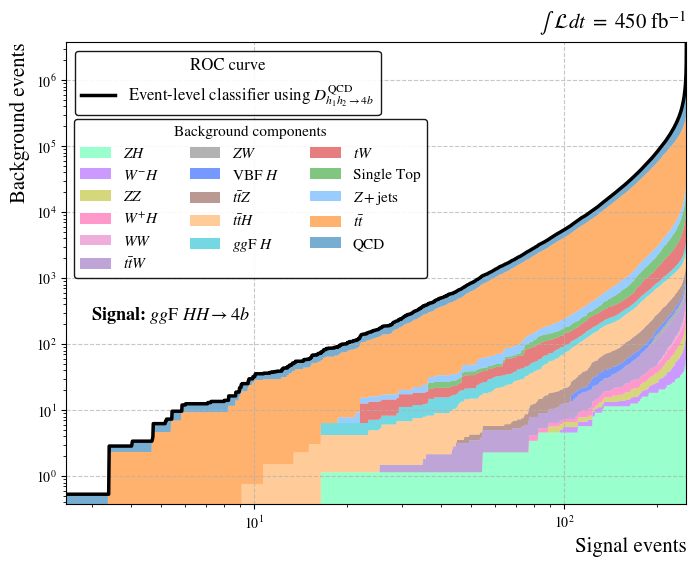

ROC curve with background composition completed.

Processing alpha=1, using discriminant: score_hh4bvsboth
Loaded QCD ratios (vsboth) from qcd_ratio_fitted_results_0p99.npz

Processing model: ensemble
Using QCD Ratio: 0.07235239008100952
Loaded saved ROC data.
Event-level classifier - Sig: 248.20, Bg: 3723681.00
Downsampling from 774459 points...

  [Downsample] Starting with 774459 points
  bg_events range: [0.00e+00, 3.72e+06]
  [Downsample] Region breakdown:
    Ultra low (< 1): 348 → 348 (kept all)
    Extreme low (1-10): 429 → 429
    Low (10-100): 1332 → 444
    Mid (100-1000): 6584 → 573
    High (≥ 1000): 765766 → 498
  [Downsample] Total: 774459 → 2292 points

-------------------------------------------------------------------------------------
Event-level classifier - Benchmark Results:
Target Sig   | Actual Sig   | Threshold  | Total Bg     | QCD          | TTbar       
-------------------------------------------------------------------------------------
20.000       | 20.01

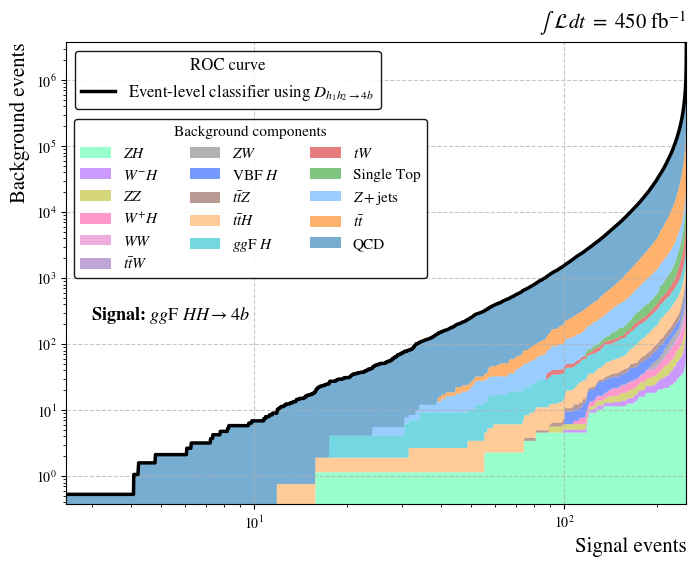

ROC curve with background composition completed.


In [2]:
# =========================================================
# 1. Helper Functions
# =========================================================

def load_qcd_ratios(min_cut_value=0.99, alpha=1):
    """
    Load pre-calculated QCD ratio data.
    Selects 'vsqcd' or 'vsboth' based on alpha.
    """
    min_cut_value_safe = str(min_cut_value).replace('.','p')
    ratio_file = f'qcd_ratio_fitted_results_{min_cut_value_safe}.npz'
    
    # Determine which ratio key to look for based on alpha/discriminant
    ratio_type = 'vsboth' if alpha == 1 else 'vsqcd'
    
    try:
        data = np.load(ratio_file)
        ratios = {}
        # The file is expected to have keys like 'ensemble_vsqcd_ratio' or 'ensemble_vsboth_ratio'
        for key in data.files:
            if key.endswith(f'_{ratio_type}_ratio'):
                model_name = key.replace(f'_{ratio_type}_ratio', '')
                ratios[model_name] = {
                    'ratio': float(data[key]),
                    'error': float(data[f'{model_name}_{ratio_type}_ratio_error'])
                }
        print(f"Loaded QCD ratios ({ratio_type}) from {ratio_file}")
        return ratios
    except FileNotFoundError:
        print(f"Warning: {ratio_file} not found. Hybrid method cannot be used.")
        return None
    except Exception as e:
        print(f"Error loading ratios: {e}")
        return None

def smart_downsample_roc(fpr, tpr, thresholds, 
                         total_background, total_signal, 
                         ultra_low_threshold=1,
                         extreme_low_threshold=10,
                         low_stat_threshold=100,
                         mid_stat_threshold=1000,
                         target_points_dict=None):
    """
    Multi-tier downsampling for hybrid ROC curves.
    Preserves step structure in ultra-low statistics region.
    """
    if target_points_dict is None:
        target_points_dict = {
            'ultra_low': None,        # < 1: keep all
            'extreme_low': 250,       # 1-10: moderate sampling
            'low': 400,               # 10-100
            'mid': 600,               # 100-1000
            'high': 500               # >= 1000
        }
    
    bg_events = fpr * total_background
    sig_events = tpr * total_signal
    n_points = len(fpr)
    
    if n_points <= 2500:
        print(f"  [Downsample] Points already small ({n_points}), skipping.")
        return fpr, tpr, thresholds, np.arange(n_points)
    
    print(f"\n  [Downsample] Starting with {n_points} points")
    print(f"  bg_events range: [{bg_events.min():.2e}, {bg_events.max():.2e}]")
    
    # Region 1: Ultra low statistics (keep all - true step structure)
    mask_ultra_low = bg_events < ultra_low_threshold
    idx_ultra_low = np.where(mask_ultra_low)[0]
    
    # Region 2: Extreme low statistics (moderate downsampling)
    mask_extreme_low = (bg_events >= ultra_low_threshold) & (bg_events < extreme_low_threshold)
    idx_extreme_candidates = np.where(mask_extreme_low)[0]
    
    if len(idx_extreme_candidates) > target_points_dict['extreme_low']:
        step = max(1, len(idx_extreme_candidates) // target_points_dict['extreme_low'])
        idx_extreme_low = idx_extreme_candidates[::step]
    else:
        idx_extreme_low = idx_extreme_candidates
    
    # Region 3: Low statistics (moderate downsampling)
    mask_low = (bg_events >= extreme_low_threshold) & (bg_events < low_stat_threshold)
    idx_low_candidates = np.where(mask_low)[0]
    
    if len(idx_low_candidates) > target_points_dict['low']:
        step = max(1, len(idx_low_candidates) // target_points_dict['low'])
        idx_low = idx_low_candidates[::step]
    else:
        idx_low = idx_low_candidates
    
    # Region 4: Mid statistics (log sampling)
    mask_mid = (bg_events >= low_stat_threshold) & (bg_events < mid_stat_threshold)
    idx_mid_candidates = np.where(mask_mid)[0]
    
    if len(idx_mid_candidates) > target_points_dict['mid']:
        bg_mid = bg_events[idx_mid_candidates]
        sig_mid = sig_events[idx_mid_candidates]
        
        n_samples = target_points_dict['mid'] // 2
        
        target_bg = np.logspace(np.log10(max(bg_mid.min(), 1e-10)), 
                               np.log10(bg_mid.max()), n_samples)
        idx_bg = np.searchsorted(bg_mid, target_bg)
        
        target_sig = np.logspace(np.log10(max(sig_mid.min(), 1e-10)), 
                                np.log10(sig_mid.max()), n_samples)
        idx_sig = np.searchsorted(sig_mid, target_sig)
        
        idx_mid_local = np.unique(np.concatenate([idx_bg, idx_sig]))
        idx_mid_local = np.clip(idx_mid_local, 0, len(idx_mid_candidates) - 1)
        idx_mid = idx_mid_candidates[idx_mid_local]
    else:
        idx_mid = idx_mid_candidates
    
    # Region 5: High statistics (sparse log sampling)
    mask_high = bg_events >= mid_stat_threshold
    idx_high_candidates = np.where(mask_high)[0]
    
    if len(idx_high_candidates) > target_points_dict['high']:
        bg_high = bg_events[idx_high_candidates]
        sig_high = sig_events[idx_high_candidates]
        
        n_samples = target_points_dict['high'] // 2
        
        target_bg = np.logspace(np.log10(bg_high.min()), np.log10(bg_high.max()), n_samples)
        idx_bg = np.searchsorted(bg_high, target_bg)
        
        target_sig = np.logspace(np.log10(max(sig_high.min(), 1e-10)), 
                                np.log10(sig_high.max()), n_samples)
        idx_sig = np.searchsorted(sig_high, target_sig)
        
        idx_high_local = np.unique(np.concatenate([idx_bg, idx_sig]))
        idx_high_local = np.clip(idx_high_local, 0, len(idx_high_candidates) - 1)
        idx_high = idx_high_candidates[idx_high_local]
    else:
        idx_high = idx_high_candidates
    
    # Merge all indices
    idx_final = np.unique(np.concatenate([
        idx_ultra_low, idx_extreme_low, idx_low, idx_mid, idx_high
    ]))
    idx_final = np.sort(idx_final)
    
    # Ensure first and last points are included
    if len(idx_final) > 0:
        if idx_final[0] != 0:
            idx_final = np.insert(idx_final, 0, 0)
        if idx_final[-1] != n_points - 1:
            idx_final = np.append(idx_final, n_points - 1)
    
    print(f"  [Downsample] Region breakdown:")
    print(f"    Ultra low (< {ultra_low_threshold}): {len(idx_ultra_low)} → {len(idx_ultra_low)} (kept all)")
    print(f"    Extreme low ({ultra_low_threshold}-{extreme_low_threshold}): {len(idx_extreme_candidates)} → {len(idx_extreme_low)}")
    print(f"    Low ({extreme_low_threshold}-{low_stat_threshold}): {len(idx_low_candidates)} → {len(idx_low)}")
    print(f"    Mid ({low_stat_threshold}-{mid_stat_threshold}): {len(idx_mid_candidates)} → {len(idx_mid)}")
    print(f"    High (≥ {mid_stat_threshold}): {len(idx_high_candidates)} → {len(idx_high)}")
    print(f"  [Downsample] Total: {n_points} → {len(idx_final)} points\n")
    
    return fpr[idx_final], tpr[idx_final], thresholds[idx_final], idx_final


def calculate_total_hybrid_roc(signal_data, qcd_circle_data, qcd_ellipse_data, other_bg_data, 
                               qcd_ratio, threshold_switch=0.99):
    """
    Calculates the Total ROC curve using:
    - Signal: Standard weighted count
    - QCD: Hybrid method (Circle*Ratio if > 0.99, else Ellipse)
    - Other Backgrounds: Standard weighted count (Ellipse)
    """
    print("Calculating Total Hybrid ROC...")
    
    # 1. Collect all scores to define thresholds
    all_scores = []
    if signal_data: all_scores.append(np.concatenate([d['score'] for d in signal_data]))
    if qcd_circle_data: all_scores.append(np.concatenate([d['score'] for d in qcd_circle_data]))
    if qcd_ellipse_data: all_scores.append(np.concatenate([d['score'] for d in qcd_ellipse_data]))
    if other_bg_data: all_scores.append(np.concatenate([d['score'] for d in other_bg_data]))
    
    all_scores_flat = np.concatenate(all_scores)
    
    # Sort unique scores descending to create thresholds
    # Downsample thresholds if too many to speed up calculation
    unique_scores = np.unique(all_scores_flat)
    thresholds = np.sort(unique_scores)[::-1]
    
    if len(thresholds) > 10000:
        # Keep high precision near 1.0 and 0.99
        high_score_mask = thresholds > 0.98
        low_score_thresh = thresholds[~high_score_mask][::10] # Downsample low scores
        thresholds = np.concatenate([thresholds[high_score_mask], low_score_thresh])
        thresholds = np.sort(thresholds)[::-1]

    # 2. Helper to calculate weighted yields > threshold
    def get_yields(data_list, thresh_arr):
        if not data_list:
            return np.zeros_like(thresh_arr)
        
        scores = np.concatenate([d['score'] for d in data_list])
        weights = np.concatenate([d['weight'] for d in data_list])
        
        # Sort by score descending
        idx = np.argsort(scores)[::-1]
        scores_sorted = scores[idx]
        weights_sorted = weights[idx]
        
        # Cumulative sum of weights
        cumsum_weights = np.cumsum(weights_sorted)
        
        # Find indices in sorted scores corresponding to thresholds
        # searchsorted finds the first index where score <= threshold (since sorted descending, this is tricky)
        # Actually, for descending array: searchsorted with side='right' (default for sorter) works on ascending.
        # Let's use searchsorted on -scores (ascending) and -thresholds
        
        idx_thresh = np.searchsorted(-scores_sorted, -thresh_arr, side='left')
        
        # Yield is the value at idx_thresh - 1 (if idx > 0)
        yields = np.zeros_like(thresh_arr)
        valid_mask = idx_thresh > 0
        
        # If idx_thresh == len, it means all scores are > threshold (wait, no)
        # -scores: [-1.0, -0.9, ...]
        # -thresh: -0.95
        # searchsorted finds index where -0.95 would be inserted.
        # Elements to the left are smaller (more negative, i.e., higher original score).
        # So we take cumsum at idx_thresh - 1.
        
        yields[valid_mask] = cumsum_weights[idx_thresh[valid_mask] - 1]
        return yields

    # 3. Calculate yields for each component
    sig_yields = get_yields(signal_data, thresholds)
    qcd_circle_yields = get_yields(qcd_circle_data, thresholds)
    qcd_ellipse_yields = get_yields(qcd_ellipse_data, thresholds)
    other_bg_yields = get_yields(other_bg_data, thresholds)
    
    # 4. Apply Hybrid Logic for QCD
    # If threshold > switch: use Circle * Ratio
    # If threshold <= switch: use Ellipse
    use_ratio = thresholds > threshold_switch
    
    qcd_final_yields = np.where(
        use_ratio,
        qcd_circle_yields * qcd_ratio,
        qcd_ellipse_yields
    )
    
    # 5. Combine Backgrounds
    total_bg_yields = qcd_final_yields + other_bg_yields
    
    # 6. Calculate Totals for Normalization
    total_sig_norm = sig_yields[-1] if len(sig_yields) > 0 else 1.0
    
    # Total background norm is the yield at the lowest threshold (0)
    # Note: For hybrid method, the norm is implicitly defined by the curve at 0.
    total_bg_norm = total_bg_yields[-1] if len(total_bg_yields) > 0 else 1.0
    
    tpr = sig_yields / total_sig_norm
    fpr = total_bg_yields / total_bg_norm
    
    # Calculate AUC (Trapezoidal to handle potential non-monotonicity at stitch point)
    auc = np.trapz(tpr, fpr)
    
    return fpr, tpr, thresholds, auc, total_sig_norm, total_bg_norm

# =========================================================
# 2. Main Configuration
# =========================================================

lumi_scale = 4.5 # 450 fb^-1
a_param = 15
b_param = 10
circle_center_x = 125
circle_center_y = 125
circle_radius = 45

# Weight dictionary
weight_dict = { 
    "QCD": lumi_scale * 4.5226e+06 * 1e5 / ((17600+38072) * 50e5),
    "ZJetsToQQ": lumi_scale * 1253.61 * 1e5 / (4000 * 1e5), 
    "TTbar": lumi_scale * 83175900 / (40305472 + 120928855),
    "SingleTop": lumi_scale * 18487900 / 17032212,
    "TW": lumi_scale * 6496000 / 4694318,
    "TTbarW": lumi_scale * 74530 / 1000000,
    "TTbarZ": lumi_scale * 85900 / 1000000,
    "WW": lumi_scale * 11870000 / 14330905,
    "ZW": lumi_scale * 4674000 / 7117197,
    "ZZ": lumi_scale * 1691000 / 7055884,
    "SingleHiggs": lumi_scale * 4858000 / 10000000,
    "VBFH": lumi_scale * 378200 / 1000000,
    "WplusH": lumi_scale * 83990 / 499991,
    "WminusH": lumi_scale * 53270 / 499999,
    "ZH": lumi_scale * 76120 / 300000,
    "ttH": lumi_scale * 50710 / 300000,
    "ggHH": lumi_scale * 1051.7 / 10000000,
    "qqHH": lumi_scale * 58.5 / 3000000
}

ntuple_base_dir = "/data/bond/tyyang99/HH4b/ensemble_method2_ntuples_cdfv2"
clear = False
alpha_list = [0,1]

# =========================================================
# 3. Main Loop
# =========================================================

for alpha in alpha_list:

    alpha_name = str(alpha).replace(".","p")

    if alpha == 0:
        discriminant = 'score_hh4bvsqcd'  
    elif alpha == 1:
        discriminant = 'score_hh4bvsboth'  
    else:
        discriminant = 'score_hh4bvsboth'  
    
    print(f"\nProcessing alpha={alpha}, using discriminant: {discriminant}")
    
    # Load QCD Ratios for this alpha
    qcd_ratios = load_qcd_ratios(min_cut_value=0.99, alpha=alpha)
    
    background_processes = ['QCD', 'TTbar', 'SingleTop', 'TW', 'TTbarW', 'TTbarZ', 'WW', 'ZW', 'ZZ', 'SingleHiggs', 'VBFH', 'WplusH', 'WminusH', 'ZH', 'ttH', 'ZJetsToQQ']
    
    process_colors = {
        'QCD': '#1f77b4', 'TTbar': '#ff7f0e', 'SingleTop': '#2ca02c', 'TW': '#d62728',
        'TTbarW': '#9467bd', 'TTbarZ': '#8c564b', 'WW': '#e377c2', 'ZW': '#7f7f7f',
        'ZZ': '#bcbd22', 'SingleHiggs': '#17becf', 'VBFH': '#1a55FF', 'WplusH': '#FF55AA',
        'WminusH': '#AA55FF', 'ZH': '#55FFAA', 'ttH': '#FFAA55', 'ZJetsToQQ': '#55AAFF'
    }
    
    process_labels = {
        'QCD': 'QCD', 'TTbar': r'$t\bar{t}$', 'SingleTop': 'Single Top', 'TW': '$tW$',
        'TTbarW': r'$t\bar{t}W$', 'TTbarZ': r'$t\bar{t}Z$', 'WW': '$WW$', 'ZW': '$ZW$',
        'ZZ': '$ZZ$', 'SingleHiggs': r'$gg\mathrm{F}$ $H$', 'VBFH': 'VBF $H$',
        'WplusH': '$W^{+}H$', 'WminusH': '$W^{-}H$', 'ZH': '$ZH$', 'ttH': r'$t\bar{t}H$',
        'ZJetsToQQ': r'$Z+\mathrm{jets}$'
    }
    
    models = [
        {"name": "ensemble", "label": "Event-level classifier", "color": "black", "marker": "*"},
    ]
    
    def find_threshold_for_signal_events(signal_events_array, thresholds_array, target_signal_events):
        if signal_events_array[0] > signal_events_array[-1]:
            pass
        else:
            signal_events_array = signal_events_array[::-1]
            thresholds_array = thresholds_array[::-1]
        idx = np.argmin(np.abs(signal_events_array - target_signal_events))
        return thresholds_array[idx], signal_events_array[idx]
    
    roc_data_dir = "roc_data_fullbg"
    os.makedirs(roc_data_dir, exist_ok=True)
    process_comp_dir = "process_composition"
    os.makedirs(process_comp_dir, exist_ok=True)
    
    # -------------------------------------------------------------------------
    # Function: Get Background Composition (Modified for Hybrid QCD)
    # -------------------------------------------------------------------------
    def get_background_composition_hist(model_name, thresholds, qcd_ratio_val=None):
        if model_name == "ensemble":
            model_safe_name = "ensemble"
        else:
            model_safe_name = model_name.replace("../../predict/","").replace("/", "_").replace(".", "_")
        
        comp_file = f"{process_comp_dir}/alpha{alpha_name}_{model_safe_name}_bg_composition.npz"
        if clear:
            os.popen(f"rm -f {comp_file}").read()
            
        try:
            with np.load(comp_file) as data:
                return {proc: data[proc] for proc in background_processes if proc in data.files}
        except:
            print(f"Computing background composition for {model_name}...")
            
            # Create bins for histogram
            fixed_thresholds = thresholds.copy()
            fixed_thresholds[np.isinf(fixed_thresholds)] = 1.0
            fixed_thresholds[fixed_thresholds > 1.0] = 1.0
            fixed_thresholds[fixed_thresholds < 0.0] = 0.0
            sorted_thresholds = np.sort(fixed_thresholds)[::-1]
            
            high_precision_thresholds = sorted_thresholds[:1000]
            remaining_thresholds = sorted_thresholds[1000:]
            
            if len(remaining_thresholds) > 0:
                num_samples = min(2000, max(500, len(remaining_thresholds) // 100))
                if len(remaining_thresholds) > 1:
                    log_indices = np.logspace(np.log10(1), np.log10(len(remaining_thresholds)), num_samples).astype(int) - 1
                    log_indices = np.unique(log_indices)
                    sampled_thresholds = remaining_thresholds[log_indices]
                else:
                    sampled_thresholds = remaining_thresholds
                bins = np.concatenate([high_precision_thresholds, sampled_thresholds])
            else:
                bins = high_precision_thresholds
    
            if bins[-1] > 0: bins = np.append(bins, 0.0)
            bins = np.sort(bins)
            
            print(f"Using {len(bins)} bins for histogram")
            
            bg_composition_at_thresholds = {}
            
            # Loop through processes
            for proc_name in background_processes:
                proc_dir = os.path.join(ntuple_base_dir, proc_name)
                if not os.path.exists(proc_dir): continue
                
                print(f"Processing {proc_name} for background composition...")
                
                # For QCD, we need two histograms: Circle and Ellipse
                is_qcd = (proc_name == 'QCD') and (qcd_ratio_val is not None)
                
                hist_accum = np.zeros(len(bins)-1)
                hist_accum_circle = np.zeros(len(bins)-1) # Only used for QCD
                
                ntuple_files = glob.glob(os.path.join(proc_dir, "ensemble_method2_*.root"))
                
                for i, ntuple_file in enumerate(ntuple_files):
                    try:
                        with uproot.open(ntuple_file) as f:
                            tree = f["tree"]
                            branches = [
                                f'model0_{discriminant}', f'model1_{discriminant}', f'model2_{discriminant}',
                                'combined_basic_fit_cut', 'ensemble_final_peak_x', 'ensemble_final_peak_y', 'weight'
                            ]
                            data = tree.arrays(branches)
                        
                        cut_mask = data['combined_basic_fit_cut'] == 1
                        if ak.sum(cut_mask) == 0: continue
                        
                        final_peak_x = data['ensemble_final_peak_x'][cut_mask]
                        final_peak_y = data['ensemble_final_peak_y'][cut_mask]
                        
                        # Calculate scores
                        s0 = ak.to_numpy(data[f'model0_{discriminant}'][cut_mask])
                        s1 = ak.to_numpy(data[f'model1_{discriminant}'][cut_mask])
                        s2 = ak.to_numpy(data[f'model2_{discriminant}'][cut_mask])
                        ensemble_scores = (s0 + s1 + s2) / 3.0
                        weights = ak.to_numpy(data['weight'][cut_mask])
                        
                        # 1. Ellipse Cut (Standard for all)
                        ellipse_mask = (
                            ((final_peak_x + final_peak_y - 250)**2 / (2 * a_param**2) +
                             (final_peak_x - final_peak_y)**2 / (2 * b_param**2)) < 1
                        )
                        
                        if ak.sum(ellipse_mask) > 0:
                            hist, _ = np.histogram(ensemble_scores[ellipse_mask], bins=bins, weights=weights[ellipse_mask])
                            hist_accum += hist
                            
                        # 2. Circle Cut (Only for QCD Hybrid)
                        if is_qcd:
                            circle_mask = (
                                (final_peak_x - circle_center_x)**2 + 
                                (final_peak_y - circle_center_y)**2 < circle_radius**2
                            )
                            if ak.sum(circle_mask) > 0:
                                hist_c, _ = np.histogram(ensemble_scores[circle_mask], bins=bins, weights=weights[circle_mask])
                                hist_accum_circle += hist_c

                    except Exception as e:
                        print(f"  Error loading {ntuple_file}: {e}")
                        continue
                
                # Calculate Cumulative Sums (Reverse: count > threshold)
                cumsum_ellipse = np.cumsum(hist_accum[::-1])[::-1]
                
                if is_qcd:
                    cumsum_circle = np.cumsum(hist_accum_circle[::-1])[::-1]
                    # Apply Hybrid Logic based on bin edges (bins are sorted ascending)
                    # bins[:-1] are the lower edges of the bins. 
                    # Actually, we want to know if the threshold is > 0.99.
                    # The cumsum array corresponds to thresholds at bins[:-1] (roughly).
                    
                    # Let's map exactly:
                    # cumsum[i] is count of events with score >= bins[i]
                    
                    use_ratio = bins[:-1] > 0.99
                    final_cumsum = np.where(use_ratio, cumsum_circle * qcd_ratio_val, cumsum_ellipse)
                    bg_composition_at_thresholds[proc_name] = np.zeros_like(thresholds)
                    
                    # Store for interpolation
                    source_cumsum = final_cumsum
                else:
                    bg_composition_at_thresholds[proc_name] = np.zeros_like(thresholds)
                    source_cumsum = cumsum_ellipse
                
                # Interpolate to requested thresholds
                # bins[:-1] are the x-values (thresholds) for source_cumsum
                x_vals = bins[:-1]
                y_vals = source_cumsum
                
                # Use searchsorted/interp logic
                # Since thresholds are arbitrary, we find nearest bin
                for idx, th in enumerate(thresholds):
                    if th <= 0:
                        bg_composition_at_thresholds[proc_name][idx] = y_vals[0]
                    elif th >= 1:
                        bg_composition_at_thresholds[proc_name][idx] = 0
                    else:
                        bin_idx = np.searchsorted(x_vals, th) - 1
                        if bin_idx < 0: bin_idx = 0
                        if bin_idx >= len(y_vals): bin_idx = len(y_vals) - 1
                        bg_composition_at_thresholds[proc_name][idx] = y_vals[bin_idx]

            np.savez(comp_file, **bg_composition_at_thresholds)
            return bg_composition_at_thresholds

    # -------------------------------------------------------------------------
    # Plotting Loop
    # -------------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for model_config in models:
        model_name = model_config["name"]
        model_safe_name = "ensemble" if model_name == "ensemble" else model_name.replace("../../predict/","").replace("/", "_").replace(".", "_")
        
        print(f"\nProcessing model: {model_name}")
        
        roc_file = f"{roc_data_dir}/alpha{alpha_name}_{model_safe_name}_roc_data.npz"
        if clear: os.popen(f"rm -f {roc_file}").read()
        
        # Get Ratio Value for this model
        qcd_ratio_val = None
        if qcd_ratios and model_name in qcd_ratios:
            qcd_ratio_val = qcd_ratios[model_name]['ratio']
            print(f"Using QCD Ratio: {qcd_ratio_val}")
        elif qcd_ratios and 'ensemble' in qcd_ratios:
             # Fallback for ensemble if name matches
             qcd_ratio_val = qcd_ratios['ensemble']['ratio']
             print(f"Using QCD Ratio (Ensemble default): {qcd_ratio_val}")
        
        try:
            with np.load(roc_file) as data:
                fpr = data['fpr']
                tpr = data['tpr']
                auc = data['auc']
                thresholds = data['thresholds']
                total_signal = data['signal']
                total_background = data['background']
                print("Loaded saved ROC data.")
        except:
            print("Calculating ROC from scratch with Hybrid QCD method...")
            
            signal_data = []
            qcd_circle_data = []
            qcd_ellipse_data = []
            other_bg_data = []
            
            # Only implementing for 'ensemble' as per user request logic
            if model_name == "ensemble":
                for proc_name in list(weight_dict.keys()):
                    if proc_name == 'qqHH': continue
                    
                    proc_dir = os.path.join(ntuple_base_dir, proc_name)
                    if not os.path.exists(proc_dir): continue
                    
                    is_signal = proc_name in ["ggHH", "qqHH"]
                    is_qcd = proc_name == "QCD"
                    
                    ntuple_files = glob.glob(os.path.join(proc_dir, "ensemble_method2_*.root"))
                    print(f"Loading {proc_name} ({len(ntuple_files)} files)...")
                    
                    for ntuple_file in ntuple_files:
                        try:
                            with uproot.open(ntuple_file) as f:
                                tree = f["tree"]
                                data = tree.arrays([
                                    f'model0_{discriminant}', f'model1_{discriminant}', f'model2_{discriminant}',
                                    'combined_basic_fit_cut', 'ensemble_final_peak_x', 'ensemble_final_peak_y', 'weight'
                                ])
                            
                            cut_mask = data['combined_basic_fit_cut'] == 1
                            if ak.sum(cut_mask) == 0: continue
                            
                            final_peak_x = data['ensemble_final_peak_x'][cut_mask]
                            final_peak_y = data['ensemble_final_peak_y'][cut_mask]
                            
                            s0 = ak.to_numpy(data[f'model0_{discriminant}'][cut_mask])
                            s1 = ak.to_numpy(data[f'model1_{discriminant}'][cut_mask])
                            s2 = ak.to_numpy(data[f'model2_{discriminant}'][cut_mask])
                            ensemble_scores = (s0 + s1 + s2) / 3.0
                            weights = ak.to_numpy(data['weight'][cut_mask])
                            
                            # 1. Ellipse Selection (Signal, Other BG, and QCD-Low-Score)
                            ellipse_mask = (
                                ((final_peak_x + final_peak_y - 250)**2 / (2 * a_param**2) +
                                 (final_peak_x - final_peak_y)**2 / (2 * b_param**2)) < 1
                            )
                            
                            if ak.sum(ellipse_mask) > 0:
                                w_data = {'score': ensemble_scores[ellipse_mask], 'weight': weights[ellipse_mask]}
                                if is_signal:
                                    signal_data.append(w_data)
                                elif is_qcd:
                                    qcd_ellipse_data.append(w_data)
                                else:
                                    other_bg_data.append(w_data)
                            
                            # 2. Circle Selection (QCD-High-Score only)
                            if is_qcd:
                                circle_mask = (
                                    (final_peak_x - circle_center_x)**2 + 
                                    (final_peak_y - circle_center_y)**2 < circle_radius**2
                                )
                                if ak.sum(circle_mask) > 0:
                                    w_data = {'score': ensemble_scores[circle_mask], 'weight': weights[circle_mask]}
                                    qcd_circle_data.append(w_data)
                                    
                        except Exception as e:
                            print(f"Error: {e}")
                            continue

            # Calculate Hybrid ROC
            if qcd_ratio_val is None:
                print("Error: QCD Ratio not found. Cannot compute Hybrid ROC.")
                continue
                
            fpr, tpr, thresholds, auc, total_signal, total_background = calculate_total_hybrid_roc(
                signal_data, qcd_circle_data, qcd_ellipse_data, other_bg_data, qcd_ratio_val
            )
            
            np.savez(roc_file, fpr=fpr, tpr=tpr, thresholds=thresholds, auc=auc,
                     signal=total_signal, background=total_background)

        print(f"{model_config['label']} - Sig: {total_signal:.2f}, Bg: {total_background:.2f}")
        reference_total_signal = total_signal
        reference_total_background = total_background
        
        # Get Background Composition (with Hybrid Logic for QCD)
        bg_composition = get_background_composition_hist(model_name, thresholds, qcd_ratio_val)

        # Downsample for plotting
        if len(fpr) > 5000:
            print(f"Downsampling from {len(fpr)} points...")
            fpr_sm, tpr_sm, thresholds_sm, indices = smart_downsample_roc(
                fpr, tpr, thresholds, total_background, total_signal,
                ultra_low_threshold=1,
                extreme_low_threshold=10,
                low_stat_threshold=100,
                mid_stat_threshold=1000
            )
            fpr, tpr, thresholds = fpr_sm, tpr_sm, thresholds_sm
            for proc in bg_composition:
                bg_composition[proc] = bg_composition[proc][indices]


        # Convert to events
        signal_events = tpr * total_signal
        background_events = fpr * total_background
        signal_events_rev = signal_events[::-1] # Low score to High score (High eff to Low eff)
        
        # Prepare Stack Plot Data
        active_processes = [p for p in background_processes if p in bg_composition and np.any(bg_composition[p] > 0)]
        proc_contributions = {p: bg_composition[p][::-1][0] for p in active_processes} # contribution at lowest threshold
        sorted_processes = sorted(active_processes, key=lambda p: proc_contributions[p])
        
        stack_data = []
        stack_colors = []
        stack_labels = []
        
        for proc in sorted_processes:
            # Reverse composition array to match signal_events_rev (increasing signal efficiency)
            stack_data.append(bg_composition[proc][::-1])
            stack_colors.append(process_colors[proc])
            stack_labels.append(process_labels[proc])
            
        if stack_data:
            ax.stackplot(signal_events_rev, np.vstack(stack_data), colors=stack_colors, labels=stack_labels, alpha=0.6)
        
        # Plot ROC Curve
        label_suffix = r" using $D_{h_1 h_2\to 4b}$" if alpha==1 else r" using $D_{h_1 h_2\to 4b}^{\mathrm{QCD}}$"
        ax.plot(signal_events, background_events, color=model_config['color'], linewidth=2.5,
                label=f"{model_config['label']}{label_suffix}")
        
        # Print Benchmark Points
        print("-" * 85)
        print(f"{model_config['label']} - Benchmark Results:")
        print(f"{'Target Sig':<12} | {'Actual Sig':<12} | {'Threshold':<10} | {'Total Bg':<12} | {'QCD':<12} | {'TTbar':<12}")
        print("-" * 85)

        for target_signal in [20, 20.504, 25, 31.275]:
            # Find the threshold and actual signal closest to target
            th_val, act_sig = find_threshold_for_signal_events(signal_events, thresholds, target_signal)
            
            # Find the index in the current arrays corresponding to this threshold
            # Using argmin(abs) is safer than where(==) for floating point comparisons
            idx = np.argmin(np.abs(thresholds - th_val))
            
            # Get Total Background
            total_bg_val = background_events[idx]
            
            # Get QCD and TTbar counts from the composition dictionary
            # Use .get() to safely handle cases where a process might be missing (defaults to 0)
            qcd_val = bg_composition.get('QCD', np.zeros_like(thresholds))[idx]
            ttbar_val = bg_composition.get('TTbar', np.zeros_like(thresholds))[idx]
            
            print(f"{target_signal:<12.3f} | {act_sig:<12.3f} | {th_val:<10.9f} | {total_bg_val:<12.3f} | {qcd_val:<12.3f} | {ttbar_val:<12.3f}")
        
        print("-" * 85)


    # -------------------------------------------------------------------------
    # Finalize Plot
    # -------------------------------------------------------------------------
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    # Scale axes using reference values
    x_min = 1e-2 * reference_total_signal
    x_max = reference_total_signal 
    y_min = 1e-7 * reference_total_background
    y_max = reference_total_background 
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel(r'Signal events', ha='right', x=1.0, fontsize=15)
    ax.set_ylabel('Background events', ha='right', y=1.0, fontsize=15)
    
    # Add text description
    ax.text(0.04, 0.4, r'Signal: $gg\mathrm{F}$ $HH\rightarrow 4b$', fontsize=13, fontweight='bold', transform=ax.transAxes)
    
    ax.text(1.0, 1.01, r'$\int~\mathcal{L}dt~=~450$ fb$^{-1}$', fontsize=15, 
            transform=ax.transAxes, ha='right', va='bottom')
    
    
    # Create two separate legends
    # 1. For the ROC curve
    handles_roc, labels_roc = [], []
    for line in ax.get_lines():
        handles_roc.append(line)
        labels_roc.append(line.get_label())
    
    # 2. For the background composition
    handles_bg, labels_bg = [], []
    for collection in ax.collections:
        if hasattr(collection, 'get_label') and collection.get_label() != '_nolegend_':
            handles_bg.append(collection)
            labels_bg.append(collection.get_label())
    
    # Add ROC legend at top left
    legend1 = ax.legend(handles_roc, labels_roc, loc='upper left', 
                       framealpha=0.9, edgecolor='black', title='ROC curve', fontsize=12, title_fontsize=12)
    
    # Get the position of the first legend
    bbox1 = legend1.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
    # Calculate the position for the second legend just below the first one
    legend2_y = bbox1.y0 - 0.02  # Small gap between legends
    
    # Add background composition legend at a fixed position below where the ROC legend is expected to be
    legend2 = plt.legend(handles_bg, labels_bg, 
                        loc='upper left',
                        bbox_to_anchor=(0, 0.85),
                        framealpha=0.9, edgecolor='black', 
                        title='Background components',
                        fontsize=11, ncol=3, title_fontsize=11)
    
    # Add the first legend back after creating the second one
    ax.add_artist(legend1)
    
    
    # Save plot
    plt.savefig(f'PLOTS/ensemble_alpha{alpha_name}_roc_with_background_composition.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'PLOTS/ensemble_alpha{alpha_name}_roc_with_background_composition.pdf', dpi=120, bbox_inches='tight')
    plt.show()
    
    print("ROC curve with background composition completed.")
